# использовал gpt, чтобы разобраться в механиках генерации текста и создании функции load_dataset

In [20]:
import torch

import os

os.environ['TRANSFORMERS_CACHE'] = '../../pretrained_models/hugging_face'

from transformers import AutoModel, AutoTokenizer, T5ForConditionalGeneration, T5Tokenizer, BartForConditionalGeneration, BartTokenizer, GPTJForCausalLM, AutoTokenizer, GPT2LMHeadModel, GPT2Tokenizer, TextDataset, DataCollatorForLanguageModeling, Trainer, TrainingArguments
import matplotlib.pyplot as plt
import numpy as np

from tqdm.auto import tqdm
import re


In [21]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [22]:
model_name = "sberbank-ai/rugpt3medium_based_on_gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)

Я буду обучать модель на своих сгенерированных текстах. Мои тексты длиннее 1024 токонов (ограничение gpt2). Для того, чтобы при создании батча из набора текстов у меня все хорошо работало, я каждый текст буду разбивать на части. Нарисую графики длины текстов в токенах для оценки величины проблемы

In [26]:
splitted_texts = [
    '../dataset/padded###/generated_curious_pushkin.txt',
    '../dataset/padded###/generated_pushkin.txt',
]

all_texts = []
for path in splitted_texts:
    with open(path, 'r', encoding='utf-8') as f:
        texts = f.read().replace('\n', '').lower()
        texts = re.sub(r'[^а-яА-ЯёЁ,.# ]', '', texts)
        texts = texts.split('#' * 10)

        all_texts += [t.strip().lower() for t in texts if len(t) > 50]

tokenized_texts = [tokenizer.encode(all_texts[i]) for i in range(len(all_texts))]

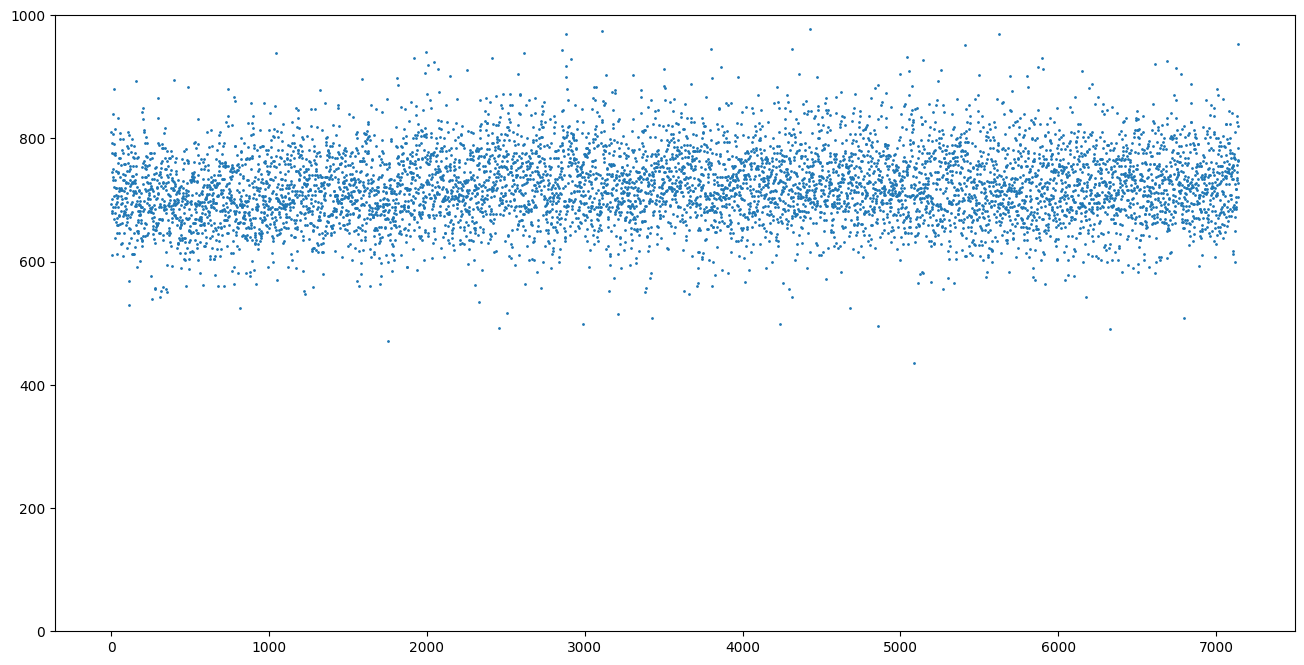

436

In [28]:
tok_lens = [len(t) for t in tokenized_texts]
plt.figure(figsize=(16, 8))
plt.ylim((0, 1000))
plt.scatter(np.arange(len(tok_lens)), tok_lens, s=1)
plt.show()
min(tok_lens)

буду каждый текст делить на 10 перехлестывающихся отрезка по 1024 токена. В таком случае размер перехлеста с каждой из сторон будет ~300 токенов, что довольно не мало с точки зрения контекста

In [15]:
# функция для создания датасета

def load_dataset(file_paths, tokenizer, block_size=512, multip=20):
    tokenized_texts = []
    for path in file_paths:
        with open(path, 'r', encoding='utf-8') as f:
            texts = f.read().replace('\n', '').lower()
            texts = re.sub(r'[^а-яА-ЯёЁ,.# ]', '', texts)
            texts = texts.split('#' * 10)

            tokenized_texts.extend([tokenizer.encode(t.strip()) for t in texts if len(t) > 50])


    # режу тексты на нахлестывающиеся отрезки
    overlapped_texts = []
    for text in tokenized_texts:
        if len(text) > block_size:
            step = max(1, (len(text) - block_size) // (multip - 1))
            for i in range(0, min(len(text) - block_size, block_size * (multip - 1) + 1), step):
                overlapped_texts.append(text[i: i + block_size])
        else:
            overlapped_texts.append(text)

    
    encodings = torch.tensor(overlapped_texts, dtype=torch.long)

    return encodings

In [16]:
dataset_paths = [
    '../dataset/generated/generated_curious_pushkin.txt',
    '../dataset/generated/generated_pushkin.txt',
]

block_size = 1024
multip = 7
train_dataset = load_dataset(dataset_paths, tokenizer, block_size=block_size)
len(train_dataset)

ValueError: expected sequence of length 693 at dim 1 (got 810)

In [ ]:
lens = [len(t) for t in train_dataset]
plt.figure(figsize=(16, 8))
plt.title('длины обрезанных текстов')
plt.scatter(np.arange(len(lens)), lens, s=0.1)



In [ ]:
num_epochs = 2

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,
)

training_args = TrainingArguments(
    output_dir=f'{model_name}_train',
    overwrite_output_dir=True,
    num_train_epochs=num_epochs,
    per_device_train_batch_size=1,
    save_steps=2_000,
    save_total_limit=2,
    fp16=True,
    logging_dir=f'{model_name}_train/logs', 
    logging_steps=1000,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset[],
)


In [ ]:
trainer.train()

path = f'{model_name}_train/{model_name}_{num_epochs}_epochs'

trainer.save_model(path)
tokenizer.save_pretrained(path)


In [ ]:
logs = trainer.state.log_history

losses = [i.get('loss') for i in logs]
plt.plot(losses)
plt.title('losses')
plt.figure(figsize=(16, 5))
plt.show()


grad = [i.get('grad_norm') for i in logs]
plt.plot(grad)
plt.title('grad_norm')
plt.figure(figsize=(16, 5))
plt.show()


In [ ]:




model_path =  f'{model_name}_train/{model_name}_{num_epochs}_epochs'


device = 'cuda' if torch.cuda.is_available() else 'cpu'



# model = T5ForConditionalGeneration.from_pretrained(model_name).to(device)
# tokenizer = T5Tokenizer.from_pretrained(model_name)


tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_path).to(device)


# tokenizer = Tokenizer.from_file('../dataset/generated/tokenizer_and_tokenized_dataset/tokenizer_2_vocab_1410_made_on_generated_data')
# model = BartForConditionalGeneration.from_pretrained(model_name)
# tokenizer = BartTokenizer.from_pretrained(model_name)

# model = T5ForConditionalGeneration.from_pretrained(model_path)
# tokenizer = T5Tokenizer.from_pretrained(model_name)

# 
torch.cuda.is_available()

In [ ]:
def generate_text(prompt, device, tokenizer):
    model.to(device)
    input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)
    output = model.generate(
        input_ids,
        min_length=512,
        max_length=1024,
        num_beams=2,
        no_repeat_ngram_size=2,
        top_k=20, 
        top_p=0.5, 
        early_stopping=True,
        do_sample=True,
        temperature=0.7, 
        

    )
    return tokenizer.decode(output[0], skip_special_tokens=True)

In [ ]:
prompt = "продолжи в стиле Пушкина: это был незабываемый рассвет над"
generated_texts = generate_text(prompt, device, tokenizer)
print(generated_texts)

In [ ]:
prompt = "это был незабываемый рассвет над"
generated_texts = generate_text(prompt, device, tokenizer)
print(generated_texts)